Данный проект является итоговой аттестационной работой в рамках профессиональной переподготовки по курсу «Python-разработчик» и содержит сквозное описание полного цикла
от определения проблемы с точки зрения продукта до получения готовой модели машинного обучения, проверки качества предсказаний на основе модели, оптимизацией гиперпараметров модели в целях повышения качества предсказаний, а также исследования возможных путей горизонтального развития полученного технологического решения.

1. Проработка бизнес-задачи проекта (проблематика проекта)

Предположим, мы трудимся в некоторой компании, пользователи интернет-сервиса которой пишут много комментариев (социальная сеть, форум, Youtube-канал). В определенный момент начали появляться много негативных комментариев, и от product-менеджера у нас поступила задача разработать систему, которая будет определять, фильтровать и/или блокировать определённые комментарии, в которых присутствует ненормативная лексика, нецензурные выражения, брань, агрессия и тому подобное. На данном этапе введём обобщающее понятие «токсичный комментарий» с отсылкой к вышеперечисленному.

Перейдём об бизнеса к задаче машинного обучения. Итак, введя понятие токсичный комментарий мы также имеем обратное понятие, которое можно сформулировать как «обычный, нейтральный, положительный». Следовательно задача сводится к следующему типу: разработать бинарный классификатор, который на вход будет получать текстовый комментарий, а на выходе будет выдавать два класса (0 — обычный, 1 — токсичный).

Необходимо максимизировать количество удалённых негативных комментариев, но при этом случайно не удалить позитивные и нейтральные комментарии, чтобы пользователи интернет-сервиса не заявили о «необоснованный цензуре» и удалённых сообщениях, оставленных ими лично и не нарушающих правил публикации на сервисе. Для этого введём ограничение на применение разрабатываемой ML-системы фильтрации, что только в одном из 20-ти случаев система имеет право ошибиться и случайно удалить обычный комментарий (не токсичный). 
Чтобы задать условие задачи, вычислим вероятность верного предсказания необходимого нам признака {100-(100/20)=95} и получим значение 95%.

Формализуем поставленную задачу через метрики:
Необходимо максимизировать recall (найденные негативные комментарии) при сохранении условия precision > 0,95 (точность предсказания признака токсичного комментария).


2. Понимание данных, составление датасета

Из-за отсутствия реального набора данных с интернет-сервиса гипотетической бизнес-компании, был осуществлён поиск большого датасета, размеченного заранее на токсичные и нетоксичные записи. В результате поиска данные взяты с сайта Kaggle.com. Как гласит описание: датасет собран из двух сервисов 2ch.hk и pikabu.ru (14412 записей). Размеченный датасе под названием labeled.csv размещен в папку data.


In [1]:
!pip install pandas
!pip install scikit-learn
!pip install nltk
!pip install numpy
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.5 MB)
  Using cached scipy-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.7 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Defaulting to user installation because normal site-packages is not writeable
  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached regex-2022.10.31-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (770 kB)
Defaulting to user installation because normal site-p

In [2]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /home/neo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/neo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#загрузим в датасет данные из размеченного CSV-файла с комментариями
df = pd.read_csv("./data/labeled.csv", sep=",")

In [4]:
#посмотрим размерность полученного датасета
df.shape

(14412, 2)

In [5]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [6]:
#преобразуем вещественные значения аттрибута класса в целочисленные
df["toxic"] = df["toxic"].apply(int)

In [7]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [8]:
#посмотрим какое распределение обычных и токсичных комментариев в размеченном датасете
df["toxic"].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [9]:
#выведем примеры нетоксичных комментариев
for c in df[df["toxic"] == 0]["comment"].head(5):
    print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [13]:
#выведем примеры токсичных комментариев
for c in df[df["toxic"] == 1]["comment"].head(5):
    print(c)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [16]:
#создадим/загрузим тестовый датасет из 500 семплов

train_df, test_df = train_test_split(df, test_size=500)
test_df.shape

(500, 2)

In [17]:
test_df["toxic"].value_counts()

0    329
1    171
Name: toxic, dtype: int64

In [18]:
train_df["toxic"].value_counts()

0    9257
1    4655
Name: toxic, dtype: int64

Распределение токсичных к нетоксичным приблизительно совпадает и составляет 1 к 2м как в тестовом датасете так и в полном. Нас это устраивает! Продолжим. 

Теперь нам нужно подготовить данные: 
    представить в виде разбивки на токены, 
    очистить от символов пунктуации, 
    убрать стоп-слова.
Затем к оставшимся токенам применим стемминг, приведя в нижний регистр и отбросив окончания.

In [19]:
sentence_example = df.iloc[11]["comment"]
tokens = word_tokenize(sentence_example, language="russian")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]


In [20]:
print(f"Исходный текст: {sentence_example}")
print("-----------------")
print(f"Токены: {tokens}")
print("-----------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("-----------------")
print(f"Токены без пунктуации и стоп слов: {tokens_without_stop_words_and_punctuation}")
print("-----------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("-----------------")

Исходный текст: Бактерия, тебе этого не понять Конечно, я же не ист е рик. Вот здесь поподробнее Сахаров А.Н вещает: Ты какой-то бред написал. Всё логично. Фраза была обращена к тебе. Твои проблемы - учись изъясняться определённее. Я заказал книгу о Второй Мировой войне на planeta.ru. Ой, извини, тогда ты не шваль - ты просто чернь. Это при условии, что ты действительно заказал маняграфию

-----------------
Токены: ['Бактерия', ',', 'тебе', 'этого', 'не', 'понять', 'Конечно', ',', 'я', 'же', 'не', 'ист', 'е', 'рик', '.', 'Вот', 'здесь', 'поподробнее', 'Сахаров', 'А.Н', 'вещает', ':', 'Ты', 'какой-то', 'бред', 'написал', '.', 'Всё', 'логично', '.', 'Фраза', 'была', 'обращена', 'к', 'тебе', '.', 'Твои', 'проблемы', '-', 'учись', 'изъясняться', 'определённее', '.', 'Я', 'заказал', 'книгу', 'о', 'Второй', 'Мировой', 'войне', 'на', 'planeta.ru', '.', 'Ой', ',', 'извини', ',', 'тогда', 'ты', 'не', 'шваль', '-', 'ты', 'просто', 'чернь', '.', 'Это', 'при', 'условии', ',', 'что', 'ты', 'действи

In [21]:
#применяем вышеприведенную предобработку для каждого из предложений в датасете
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [22]:
#перепроверим функцию на том же примере и убедимся, что наша массовая предобработка выполняется аналогично
tokenize_sentence(sentence_example)

['бактер',
 'теб',
 'поня',
 'конечн',
 'ист',
 'е',
 'рик',
 'вот',
 'поподробн',
 'сахар',
 'а.н',
 'веща',
 'ты',
 'какой-т',
 'бред',
 'написа',
 'все',
 'логичн',
 'фраз',
 'обращ',
 'теб',
 'тво',
 'проблем',
 'уч',
 'изъясня',
 'определен',
 'я',
 'заказа',
 'книг',
 'втор',
 'миров',
 'войн',
 'planeta.ru',
 'о',
 'извин',
 'швал',
 'прост',
 'черн',
 'эт',
 'услов',
 'действительн',
 'заказа',
 'маняграф']

In [23]:
#создаем Tf-idf веткторайзер
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [24]:
#вызываем функцию fit_transform и обучаем векторайзер, передав список предложений из тренировочного датасета
features = vectorizer.fit_transform(train_df["comment"]) #на выходе получаем готовые фичи

In [25]:
model = LogisticRegression(random_state=0) #создаём класс логистической регрессии
model.fit(features, train_df["toxic"]) #обучаем модель методом fit, передав фичи и тренировочный датасет

LogisticRegression(random_state=0)

In [31]:
model.predict(features[1]) #проверим предсказание на втором комментарии, в ответ получим 0 (нетоксичный)

array([0])

In [32]:
train_df["comment"].iloc[1] #прочтём комментарий и убедимся, что в нём нет ругани и признаков явной токсичности

'У меня он в холодильнике хранился, не завонял. Просто половину консервов испачкало.\n'

In [33]:
#соединяем создание фичей и модель при помощи класса pipeline, чтобы на вход подавать предложения а не вещественные вектора
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0))
]
)    

In [35]:
model_pipeline.fit(train_df["comment"], train_df["toxic"]) #

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fdfdc049f30>)),
                ('model', LogisticRegression(random_state=0))])

In [38]:
#проверяем модель с примером токсичного комментария, получаем в ответ класс 1 (токсичный)
model_pipeline.predict(["Руко жоп - он и в Африке руко жоп"])

array([1])

In [39]:
#проверяем модель с примером обычного комментария, получаем в ответ класс 0 (нетоксичный)
model_pipeline.predict(["Приветствую Вас, уважаемый покупатель"])

array([0])

In [40]:
#Измеряем метрику precision
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.8992805755395683

вероятность 89% ниже чем нас устраивет

In [43]:
#Измеряем метрику recall 
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.7309941520467836

попробуем выявить значение порога (threshold), подобрать обеспечить точность относительно precision-recall-кривой, которая нас устраивает (от 95% и выше)

In [44]:
#посчитаем значения и получим массивы precision, recall и thresholds
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])


/home/neo/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


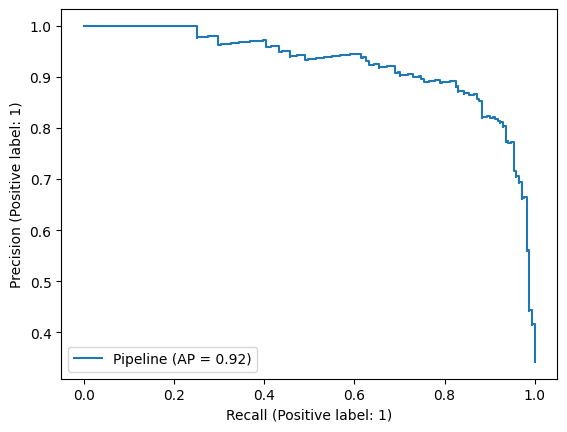

In [45]:
#визуализируем зависимость precision от recall
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])

In [46]:
np.where(prec > 0.95) #получаем индексы элементов массива, где точность больше 95%

(array([418, 419, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433,
        434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
        447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459,
        460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472,
        473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485,
        486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
        499, 500]),)

In [47]:
#напечатаем минимальный порог, который удовлетворяет нашему оценочному значению
thresholds[418]

0.6587979876052846

In [48]:
#вызываем предсказание с рассчитанным порогом
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[418])


0.9506172839506173

In [61]:
#рассчитаем recall с полученным порогом
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[418])

0.4502923976608187

Теперь в целях улучшения модели пробуем подобрать гиперпараметры.
Для этого обернём логистическую регрессию в GridSearch, чтобы поперебирать коэффициент регуляризации.

In [50]:
#создадим новый pipeline, обёрнутый в GridSearch
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3, #разбиваем на 3 фолда во время кросс-валидации
         verbose=4 #параметр с максимальным значением "4" для вывода информации об обучении
        )
    )
])

In [51]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.687 total time=   0.6s
[CV 2/3] END .............................C=0.1;, score=0.684 total time=   0.6s
[CV 3/3] END .............................C=0.1;, score=0.688 total time=   0.9s
[CV 1/3] END ...............................C=1;, score=0.837 total time=   1.3s
[CV 2/3] END ...............................C=1;, score=0.837 total time=   1.4s
[CV 3/3] END ...............................C=1;, score=0.833 total time=   1.3s


/home/neo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ............................C=10.0;, score=0.867 total time=   1.6s


/home/neo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ............................C=10.0;, score=0.869 total time=   1.5s


/home/neo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ............................C=10.0;, score=0.865 total time=   1.8s


/home/neo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fdfdaace710>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [52]:
#Лучший результат с коэфф. регуляризации = 10 (>0,86). Обучим модель с коэфф. регуляризации = 10
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
]
)

In [53]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

/home/neo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fdfda4779a0>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [54]:
#создаем новую precision-recall-кривую 
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])

/home/neo/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


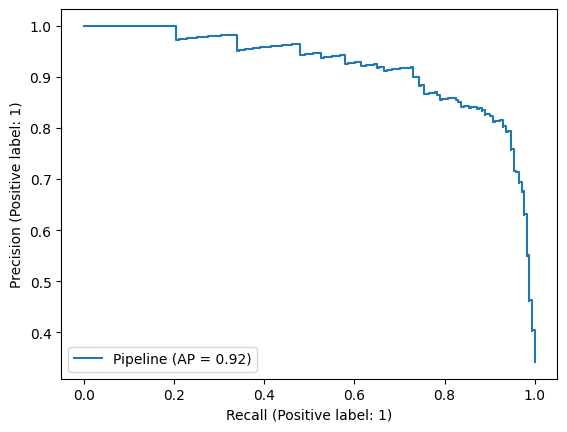

In [56]:
#рисуем на графике новую precision-recall-кривую 
plot_precision_recall_curve(estimator=model_pipeline_c_10, X=test_df["comment"], y=test_df["toxic"])

In [58]:
np.where(prec_c_10 > 0.95) #получаем индексы элементов нового массива, где точность больше 95%

(array([414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
        427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
        440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
        453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
        466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
        479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
        492, 493, 494, 495, 496, 497, 498, 499, 500]),)

In [59]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[414])

0.9647058823529412

In [62]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[414])

0.47953216374269003

Мы улучшили recall с 0.45 до 0.47 при сохранении высокой точности precision = 0.964

In [64]:
model_pipeline_c_10.predict(["Дебильный комментарий"])

array([1])

In [67]:
model_pipeline_c_10.predict(["Я хочу понять, о чём речь"])

array([0])

Мы выполнили поставленную задачу, обучить модель и протестировать уровень предсказаний на её основе. Дополнительно получилось улучшить качество предсказания за счет подбора новых пороговых значеий. В рамках учебной задачи этого достаточно. Что касается промышленного приминения, то хорошо бы иметь датасет с данными реальной продакшн-системы, размеченный вручную квалифицированным сотрудником компании либо экспертом предметной области.

Также было бы интересно расширить задачу, определяя не только токсичность комментария, но и уровень токсичности.
В качестве руководства по разметке можно было бы исользовать инструкции по распознаванию токсичности с дополнительными атрибутами, которые, по материалам habr.com, применялись на соревновании Jigsaw Toxic Comment Classification Challenge.